In [1]:
%matplotlib widget
import json
import numpy as np
import os
from glob import glob
from pprint import pprint
from pathlib import Path, PosixPath
import cv2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def dump_json(path, data):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as f:
        json.dump(data, f)
#AFLW
# "roll","pitch","yaw",
def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]

In [3]:
campose_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/campose.txt")
facepose_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/facepose.txt")
alfw_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/alfw.txt")
faceid_lines = load_text(
    "/aidata/evianlee/dataset/AFLW/aflw/data/faceid.txt") 
img_root= "/aidata/evianlee/dataset/AFLW/clean/ALFW_clean/ALFW_clean/data"
rows, cols = 1, 4
a =0
rolls, pitchs, yaws = [], [], []
tmp_dict = {}
# image71361.jpg
for i, (caampose_line, facepose_line, faceid_line) in enumerate(zip(campose_lines[1:], facepose_lines[1:], faceid_lines[1:])):
    name =str(caampose_line.split(",")[0])
    file_name = faceid_line.split(",")[1]
    tmp_str = str()
    for i, n in enumerate(file_name):
        if i > 0 and i < len(file_name) -1:
            tmp_str +=n
    name = tmp_str
    img_path = os.path.join(img_root, name)
    img = cv2.imread(img_path)
    if img is None:
        continue
    a += 1
    # "roll","pitch","yaw"
    roll = facepose_line.split(",")[1]
    tmp_str = str()
    for i, n in enumerate(roll):
        if i > 0 and i < len(roll) -1:
            tmp_str +=n
    roll = float(tmp_str) * 57.3 
    rolls.append(roll)
    
    pitch = facepose_line.split(",")[2]
    tmp_str = str()
    for i, n in enumerate(pitch):
        if i > 0 and i < len(pitch) -1:
            tmp_str +=n
    pitch = float(tmp_str) * 57.3 
    pitchs.append(pitch)
    yaw = facepose_line.split(",")[3]
    tmp_str = str()
    for i, n in enumerate(yaw):
        if i > 0 and i < len(yaw) -1:
            tmp_str +=n
    yaw = float(tmp_str) * 57.3 
    yaws.append(yaw)    
    tmp_dict[name] = [roll, pitch, yaw]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
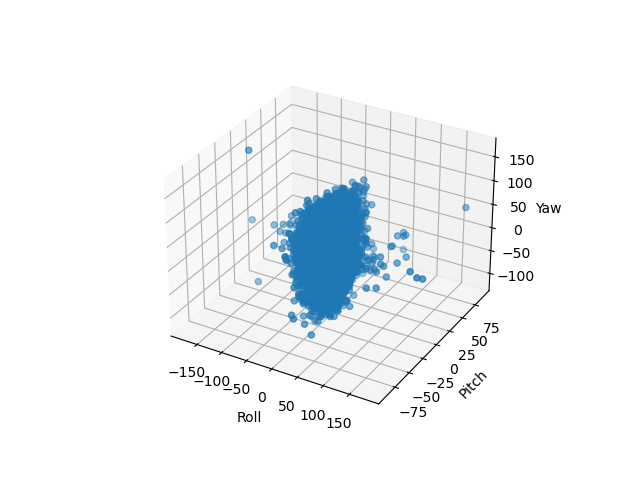

In [4]:
from mpl_toolkits.axisartist.axislines import SubplotZero
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(rolls, pitchs, yaws )
ax.set_xlabel("Roll")
ax.set_ylabel("Pitch")
ax.set_zlabel("Yaw")
plt.show()

In [5]:
from scipy.optimize import linear_sum_assignment
def calculate(gt_coords: np.ndarray, eval_coords: np.ndarray) -> np.ndarray:
    """calculate box2d iou
    output axis0:gt axis1: eval
    ref1: https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d
    ref2: https://chadrick-kwag.net/vectorized-calculatation-of-iou-and-removing-duplicate-boxes/

    Args:
        gt_boxes (np.ndarray): gt coords numpy array (N,4) in 'xyxy' format
        eval_boxes (np.ndarray): eval coords numpy array (M,4) in 'xyxy' format

    Returns:
        np.ndarray: iou
    """
    assert isinstance(gt_coords, np.ndarray) and gt_coords.ndim == 2
    assert isinstance(eval_coords, np.ndarray) and eval_coords.ndim == 2

    gt_coords[:, :2] -= 1
    eval_coords[:, :2] -= 1

    gt_x1s, gt_y1s, gt_x2s, gt_y2s = np.array_split(gt_coords, 4, axis=1)
    eval_x1s, eval_y1s, eval_x2s, eval_y2s = np.array_split(eval_coords,
                                                            4,
                                                            axis=1)
    # broadcasing
    max_x1s, max_y1s = np.maximum(gt_x1s, eval_x1s.T), np.maximum(
        gt_y1s, eval_y1s.T)
    min_x2s, min_y2s = np.minimum(gt_x2s, eval_x2s.T), np.minimum(
        gt_y2s, eval_y2s.T)
    intersections = np.maximum((min_x2s - max_x1s), 0) * np.maximum(
        (min_y2s - max_y1s), 0)
    gt_boxes_area = (gt_x2s - gt_x1s) * (gt_y2s - gt_y1s)
    eval_boxes_area = (eval_x2s - eval_x1s) * (eval_y2s - eval_y1s)
    unions = gt_boxes_area + eval_boxes_area.T - intersections

    return intersections / unions

In [6]:
gt_annos = load_json("/aidata/anders/objects/landmarks/AFLW/metrics/gt.json")
eval_annos = load_json("/aidata/anders/objects/landmarks/AFLW/metrics/eval.json")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
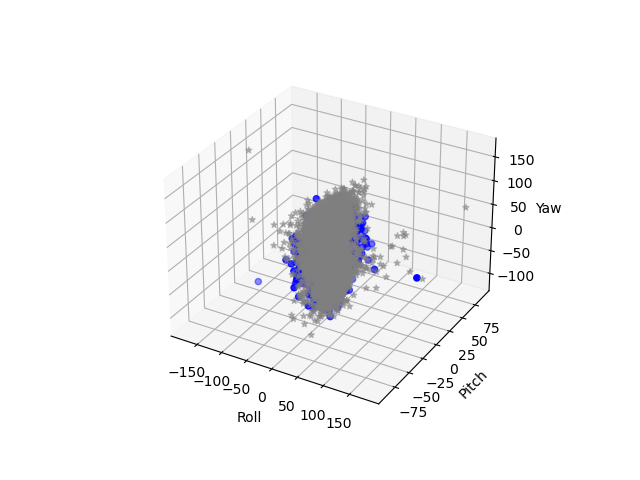

In [7]:
thresh = .5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img_root = "/aidata/anders/objects/landmarks/AFLW/imgs"

failed_preds = []
sucess_preds = []
for gt_frame, eval_frame in zip(gt_annos["frame_list"], eval_annos["frame_list"]):
    img_path = os.path.join(img_root, gt_frame["name"])
    # img = cv2.imread(img_path)
    roll, pitch, yaw = tmp_dict[gt_frame["name"]]
    gt_shapes = []
    for lb in  gt_frame["labels"]:
        gt_box2d = lb["box2d"]
        x1 = int(gt_box2d["x1"])
        y1 = int(gt_box2d["y1"])
        x2 = int(gt_box2d["x2"])
        y2 = int(gt_box2d["y2"])
        tl = (x1, y1)
        br = (x2, y2)
        gt_shapes.append([x1, y1, x2, y2])
    eval_shapes = []
    for lb in  eval_frame["labels"]:
        pred_box2d = lb["box2d"]
        x1 = int(pred_box2d["x1"])
        y1 = int(pred_box2d["y1"])
        x2 = int(pred_box2d["x2"])
        y2 = int(pred_box2d["y2"])
        tl = (x1, y1)
        br = (x2, y2)
        eval_shapes.append([x1, y1, x2, y2])
    gt_shapes, eval_shapes = np.asarray(gt_shapes), np.asarray(eval_shapes)
    if len(eval_shapes) != 0:
        cost_matrices = calculate(gt_shapes, eval_shapes)
        cost_matrices = 1- cost_matrices
        gt_idx, eval_idx = linear_sum_assignment(cost_matrices)
        match_idx = cost_matrices[gt_idx, eval_idx] <= thresh
        gt_match_idx = gt_idx[match_idx].tolist()
        eval_match_idx = eval_idx[match_idx].tolist()
        n_gt, n_eval = cost_matrices.shape
        gt_non_match_idx = list(set(range(n_gt)) - set(gt_match_idx))
        eval_non_match_idx = list(set(range(n_eval)) - set(eval_match_idx))
    if len(gt_non_match_idx) or len(eval_shapes) == 0:
        clc = 'gray'
        m =  '*'
        failed_preds.append([roll, pitch, yaw])
    else:
        clc = 'blue'
        m = 'o'
        sucess_preds.append([roll, pitch, yaw])
    #ax.scatter(roll, pitch, yaw, c=clc, marker=m)
failed_preds = np.asarray(failed_preds)
failed_roll, failed_pitch, failed_yaw = failed_preds[:, 0], failed_preds[:, 1], failed_preds[:, 2]
sucess_preds = np.asarray(sucess_preds)
sucess_roll, sucess_pitch, sucess_yaw = sucess_preds[:, 0], sucess_preds[:, 1], sucess_preds[:, 2]
ax.scatter(failed_roll, failed_pitch, failed_yaw, c='gray', marker='*', alpha = 0.5)
ax.scatter(sucess_roll, sucess_pitch, sucess_yaw, c='blue', marker='o')
ax.set_xlabel("Roll")
ax.set_ylabel("Pitch")
ax.set_zlabel("Yaw")
plt.show()
# cv2.imwrite("./output.jpg", img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
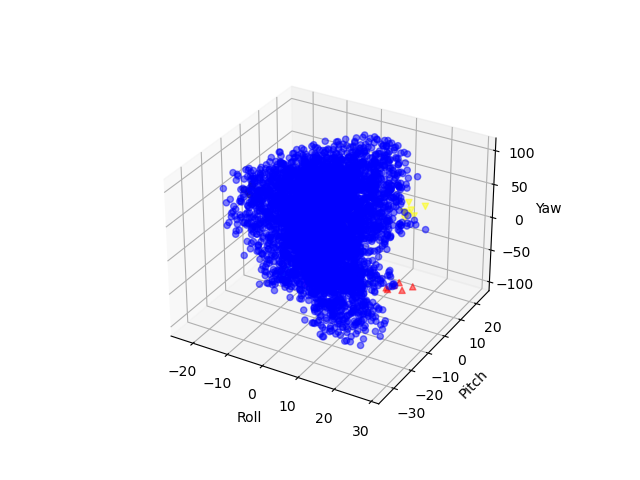

In [8]:
from sklearn.cluster import DBSCAN, KMeans
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
clcs = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "white"]
markers = ["o", "x", "^", "." , ",", "v", "o", "x", "^", "." , ",", "v"  ]
clustering = DBSCAN(eps=5,min_samples=10).fit(failed_preds)
labels = clustering.labels_
items, counts = np.unique(labels, return_counts = True)
for i, (item, cnt) in enumerate(zip(items, counts)):
    if i == 0:
        continue
    lb_index  = labels == item
    failed_lb = failed_preds[lb_index]
    failed_roll, failed_pitch, failed_yaw = failed_lb[:, 0], failed_lb[:, 1], failed_lb[:, 2]
    ax.scatter(failed_roll, failed_pitch, failed_yaw, c=clcs[i -1], marker=markers[i -1], alpha = 0.5)
ax.set_xlabel("Roll")
ax.set_ylabel("Pitch")
ax.set_zlabel("Yaw")
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
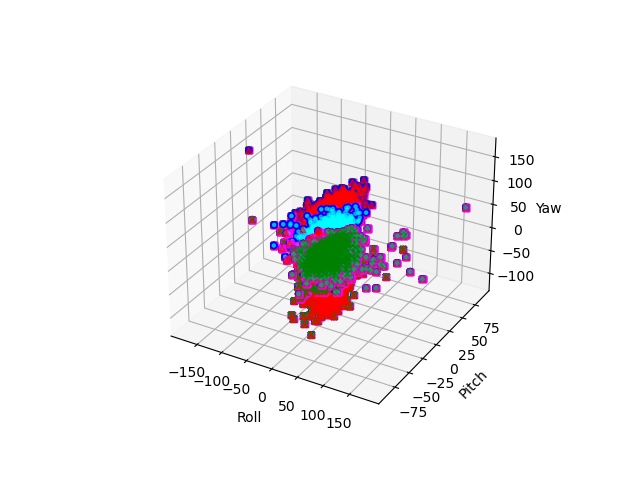

In [18]:
clcs = ["blue", "green", "red", "cyan", "magenta"]
markers = ["o", "x", "^", "." , ",", "v"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
analysis_degrees = []
for _ in range(50):
    clustering = KMeans(n_clusters = 5).fit(failed_preds)
    labels = clustering.labels_
    items, counts = np.unique(labels, return_counts = True)
    tmp = []
    for i, (item, cnt) in enumerate(zip(items, counts)):
        lb_index  = labels == item
        failed_lb = failed_preds[lb_index]
        tmp.append([cnt, np.max(failed_lb[:, 2]), np.min(failed_lb[:, 2])])
        failed_roll, failed_pitch, failed_yaw = failed_lb[:, 0], failed_lb[:, 1], failed_lb[:, 2]
        ax.scatter(failed_roll, failed_pitch, failed_yaw, c=clcs[i], marker=markers[i], alpha = 0.5)
    analysis_degrees.append(tmp)
ax.set_xlabel("Roll")
ax.set_ylabel("Pitch")
ax.set_zlabel("Yaw")
plt.show()

In [19]:
static_infos = {}
for i, degrees in enumerate(analysis_degrees):
    static_infos["data_frame_{}".format(i)] = {}
    for j, kmean_degress in enumerate(degrees):
        num_failed = kmean_degress[0]
        upper_degree, lower_degree = kmean_degress[1:]
        avg_degree = (upper_degree + lower_degree)/2
         #avg_degree = np.round(avg_degree, 1)
        mask = sucess_yaw < upper_degree
        mask_yaws = np.asarray(sucess_yaw)[mask]
        mask = list(mask_yaws) > lower_degree
        mask_yaws = np.asarray(mask_yaws)[mask]
        recall = mask_yaws.shape[0]/(num_failed + mask_yaws.shape[0])
        static_infos["data_frame_{}".format(str(i))][str(avg_degree)] = {"degree_1":upper_degree, 
                                                                        "degree_2":lower_degree,
                                                                         "recall":recall}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
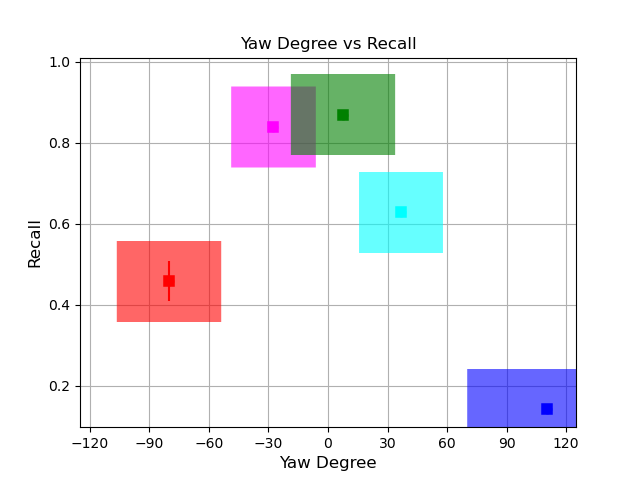

In [66]:
import copy
from matplotlib import collections
from matplotlib import colors as mcolors
yaw_mean_degrees = []
arrange_degrees = []
recalls = []
colors = [ "red", "magenta", "green", "cyan","blue"]
for i, frame_keys in enumerate(static_infos):
    K_means_infos = static_infos[frame_keys]
    keys = list(K_means_infos.keys())
    keys = np.asarray(keys).astype(np.float)
    keys = np.sort(keys)[::-1]
    yaw_mean_degrees.append(np.reshape(keys, (-1, 5)))
    info_keys = copy.deepcopy(keys)
    tmp_recalls = []
    tmp_arr_degrees = []
    for key in info_keys:
        str_key = str(key)
        degree_infos = K_means_infos[str_key]
        tmp_arr_degrees.append(np.abs(degree_infos["degree_1"] - degree_infos["degree_2"]))
        tmp_recalls.append(degree_infos["recall"])
    recalls.append(tmp_recalls)
    arrange_degrees.append(tmp_arr_degrees)
yaw_mean_degrees = np.concatenate(yaw_mean_degrees, axis = 0)
yaw_mean_degrees = np.reshape(yaw_mean_degrees, [-1, 5])
arrange_degrees = np.stack(arrange_degrees)
recalls = np.stack(recalls)
frame_wise_mu_yaw = np.mean(yaw_mean_degrees, axis = 0)[::-1]
frame_wise_std_yaw = np.std(yaw_mean_degrees, axis = 0)[::-1]
error_bars = frame_wise_std_yaw

frame_wise_mu_arrange_degrees = np.mean(arrange_degrees, axis = 0)[::-1]
bar_widths = frame_wise_mu_arrange_degrees 

frame_wise_mu_recalls = np.mean(recalls, axis = 0)[::-1]
frame_wise_std_recalls = np.std(recalls, axis = 0)[::-1]
data = {str(yaw):(rec - 0.1, rec + 0.1) for yaw, rec in zip(frame_wise_mu_yaw, frame_wise_mu_recalls)}

names = list(data.keys())   
values = list(data.values())

values = [np.arange(a[0]*10, (a[1]+0.1)*10, 2)/10 for a in values]
xs = [[float(v)]*4 for v in names]
fig,ax = plt.subplots()
for i, (x, y, bar_width, bar_err, rec, rec_err) in enumerate(zip(xs,
                                                        values, bar_widths, error_bars,
                                                        frame_wise_mu_recalls, 
                                                        frame_wise_std_recalls)):
    vert = tuple([list(zip(x, y))])

    ax.scatter(x[0], rec, c=colors[i])
    ax.errorbar(x[0], rec, yerr=rec_err, marker='s', mfc=colors[i], ms=4, mew=4, color =colors[i])
    lc = collections.LineCollection(vert, linewidths=bar_width, colors=colors[i], alpha = 0.6)
    ax.add_collection(lc)
ax.set_title('Yaw Degree vs Recall')
ax.set_ylabel('Recall', fontsize = 12)
ax.set_xlabel('Yaw Degree', fontsize = 12)
ax.set_xlim(-125, 125)

#ax.set_xticklabels(names, fontsize=8)
plt.xticks(np.arange(-120, 120+1, 30))
plt.grid()